In [1]:
import os
import torch
import pandas as pd
from sklearn import metrics
import multiprocessing as mp
from stGACN import stGACN
import scanpy as sc
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
os.environ['R_HOME'] = "/home/zhangxinming/anaconda3/envs/Test/lib/R"
dataset = '151673'

/home/zhangxinming/anaconda3/envs/Test/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# read data
file_fold = '/home/zhangxinming/stGACN-main/Data/' + str(dataset) #please replace 'file_fold' with the download path
adata = sc.read_visium(file_fold, count_file=dataset+'_filtered_feature_bc_matrix.h5', load_images=True)
adata.var_names_make_unique()

/home/zhangxinming/anaconda3/envs/Test/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [3]:
model = stGACN.stGACN(adata,beta=1,k_cutoff=3,device=device,model_select = 'KNN')
adata = model.train()

Graph_1 Construction
The graph contains 10917 edges, 3639 cells.
3.0000 neighbors per cell on average.
Graph constructed!
Graph_2 Construction
The graph contains 10917 edges, 3639 cells.
3.0000 neighbors per cell on average.
Begin to train ST data...


  0%|          | 0/800 [00:00<?, ?it/s]

Overall loss : tensor(23.6765, device='cuda:3', grad_fn=<AddBackward0>)


 13%|█▎        | 107/800 [00:04<00:25, 27.60it/s]

Overall loss : tensor(9.7083, device='cuda:3', grad_fn=<AddBackward0>)


 26%|██▌       | 204/800 [00:07<00:19, 30.27it/s]

Overall loss : tensor(9.3478, device='cuda:3', grad_fn=<AddBackward0>)


 38%|███▊      | 306/800 [00:11<00:16, 29.67it/s]

Overall loss : tensor(8.8979, device='cuda:3', grad_fn=<AddBackward0>)


 50%|█████     | 403/800 [00:14<00:12, 30.74it/s]

Overall loss : tensor(8.7562, device='cuda:3', grad_fn=<AddBackward0>)


 63%|██████▎   | 505/800 [00:17<00:09, 29.95it/s]

Overall loss : tensor(8.6547, device='cuda:3', grad_fn=<AddBackward0>)


 76%|███████▌  | 606/800 [00:21<00:06, 30.19it/s]

Overall loss : tensor(8.5992, device='cuda:3', grad_fn=<AddBackward0>)


 88%|████████▊ | 704/800 [00:24<00:03, 29.73it/s]

Overall loss : tensor(8.5111, device='cuda:3', grad_fn=<AddBackward0>)


100%|██████████| 800/800 [00:27<00:00, 28.68it/s]


Optimization finished for ST data!


In [4]:
# set radius to specify the number of neighbors considered during refinement
n_clusters = 7
radius = 30
tool = 'mclust' # mclust, leiden, and louvain
# clustering
from stGACN.utils import clustering

if tool == 'mclust':
   clustering(adata, n_clusters, radius=radius, method=tool, refinement=True) # For DLPFC dataset, we use optional refinement step.
elif tool in ['leiden', 'louvain']:
   clustering(adata, n_clusters, radius=radius, method=tool, start=0.1, end=2.0, increment=0.01, refinement=False)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [5]:
# add ground_truth
df_meta = pd.read_csv(file_fold + '/metadata.tsv', sep='\t')
df_meta_layer = df_meta['layer_guess']
adata.obs['ground_truth'] = df_meta_layer.values
# filter out NA nodes
adata = adata[~pd.isnull(adata.obs['ground_truth'])]

/home/zhangxinming/anaconda3/envs/Test/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


Dataset: 151673
ARI: 0.64650614209316
NMI 0.7485525702337223


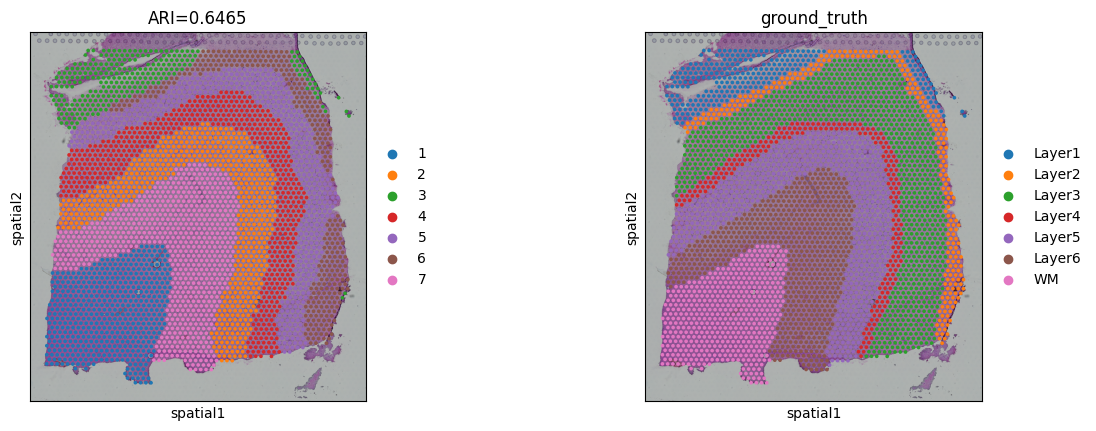

In [6]:
# calculate metric ARI
ARI = metrics.adjusted_rand_score(adata.obs['domain'], adata.obs['ground_truth'])
adata.uns['ARI'] = ARI
NMI = metrics.normalized_mutual_info_score(adata.obs['domain'], adata.obs['ground_truth'])

print('Dataset:', dataset)
print('ARI:', ARI)
print('NMI',NMI)
# plotting spatial clustering result
sc.pl.spatial(adata,
              img_key="hires",
              color=["domain",'ground_truth'],
              title=["ARI=%.4f"%ARI])